# Evaluation measures and logistic regression

## Task 1: Evaluation measures (2 points)

This task is built around the banknote authentication dataset. These data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes. Original dataset has 5 features but we have decided to keep only 2, in order to make the classification task harder. There are two classes in this task: forged (1) and genuine (0). See more details about the data at https://archive.ics.uci.edu/ml/datasets/banknote+authentication .

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
from sklearn.preprocessing import add_dummy_feature

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from IPython.display import display
%matplotlib inline
np.random.seed(0)
CRED = '\033[91m'
CEND = '\033[0m'

In [2]:
df = pd.read_csv(
    "data_banknote_authentication.txt",
    header=None,
    names=["variance", "skewness", "curtosis", "entropy", "y"],
)
df = df.drop(
    columns=["skewness", "variance"]
)  # We'll remove these two columns to make the task harder
# pd.set_option('max_rows', 10)
# display(df)
df.head(10)

,curtosis,entropy,y
0,-2.80730,-0.44699,0
1,-2.45860,-1.46210,0
2,1.92420,0.10645,0
3,-4.01120,-3.59440,0
4,4.57180,-0.98880,0
5,-3.96060,-3.16250,0
6,0.72888,0.56421,0
7,8.46360,-0.60216,0
8,-0.75345,-0.61251,0
9,-2.27180,-0.73535,0


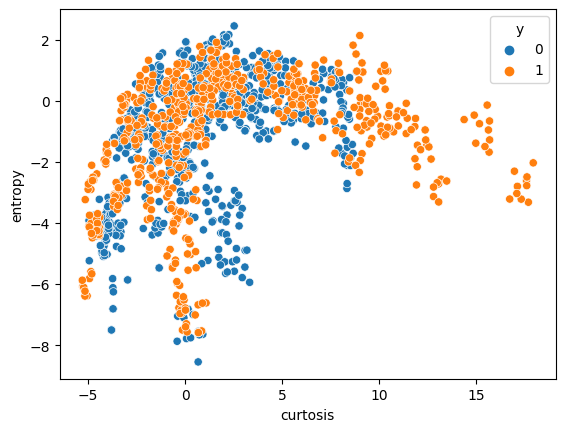

In [3]:
sns.scatterplot(x=df["curtosis"], y=df["entropy"], hue=df["y"])
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis=1),
    df.y,
    train_size=0.7,
    test_size=0.3,
    random_state=0,
    shuffle=True,
    stratify=df.y,
)
X_train.shape, X_test.shape

((960, 2), (412, 2))

Now we will train and evaluate several classifiers. We will tune them as well in order to find optimal parameters and achieve  the best possible performance.

Every `sklearn` classifier has a set of tuneable parameters, you can check the list of defaults parameters like that:

In [5]:
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

For the parameter tuning you can use Grid Search (check every possible combination of parameters from the predefined dictionary). Let us see what parameter values it found as best:

In [6]:
knn_param_grid = {
    "weights": ["uniform", "distance"],
    "n_neighbors": [1, 3, 5, 10, 15, 20, 30, 100],
}

knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=3, return_train_score=True)
knn_grid_search.fit(X_train, y_train)

"""
Weights:
    - uniform: All the points in each neighborhood are weighted equally.
    - distance: Weight points by the inverse of their distance.
"""
knn_grid_search.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

- **(a)** On the test set calculate the accuracy of the KNN model with default parameters and with the parameters selected by cross-validation. Which is better and why?

In [7]:
knn_default = KNeighborsClassifier()
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    knn_default.fit(X_train, y_train)
    knn_default_test_accuracy = accuracy_score(y_test, knn_default.predict(X_test))

    knn_tuned_test_accuracy = accuracy_score(y_test, knn_grid_search.predict(X_test))

    print("KNN test accuracy with default parameters:", knn_default_test_accuracy)
    print("KNN test accuracy after parameter tuning :", knn_tuned_test_accuracy)

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

KNN test accuracy with default parameters: 0.7257281553398058
KNN test accuracy after parameter tuning : 0.6820388349514563


In [8]:
print(
    accuracy_score(y_train, knn_default.predict(X_train)),
    accuracy_score(y_train, knn_grid_search.predict(X_train)),
)

0.8302083333333333 1.0


**<font color='purple'>Answer to (a):</font>**
The accuracy of the default KNN is higher than the tuned KNN. After inspection TunedKNN does overfit the training data and hence performs worse on the test data.

- **(b)** Look at the detailed results of cross-validation as printed below. The columns ending with '_time' are about running time, but please describe the meaning of other columns.

In [9]:
knn_cv_results = pd.DataFrame(knn_grid_search.cv_results_)
knn_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.002567,0.000769,0.014549,0.001930,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.706250,0.728125,0.70000,0.711458,0.012058,1,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.001633,0.000182,0.001815,0.000093,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.706250,0.728125,0.70000,0.711458,0.012058,1,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.002630,0.000996,0.021398,0.005944,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.706250,0.693750,0.70000,0.700000,0.005103,8,0.865625,0.853125,0.860938,0.859896,0.005156
3,0.002665,0.000279,0.003216,0.000339,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.671875,0.696875,0.70625,0.691667,0.014509,10,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.002812,0.001083,0.018955,0.004760,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.687500,0.659375,0.68750,0.678125,0.013258,13,0.812500,0.793750,0.809375,0.805208,0.008202


**<font color='purple'>Answer to (b):</font>**
- mean/std fit_time: The mean and standard deviation of the time taken to fit the model.
- mean/std score_time: The mean and standard deviation of the time taken to score the model.
- param_* : The parameters used for the model.
- split*_train/test_score: The score of the model for each fold as a training set and validation set.
- mean/std train/test_score: The mean and standard deviation of the score of the model for each fold as training set and validation set.
- rank_test_score: The rank of the model based on the mean test score.


<font color='purple'>Note that the column names involving the word 'test' might be a bit confusing - they are referring to the test fold within cross-validation, which perhaps could be better called a validation fold. Therefore, the accuracies in this table are also potentially different from what you found in subtask (b).</font>

Let us now keep only some of the columns which are the most relevant for our purpose. Also, let us sort the results by mean_test_score.

In [10]:
def cv_column_filter(df):
    return df.loc[
        :,
        [
            c
            for c in df.columns
            if (c[:11] == "mean_train_")
            or (c[:10] == "mean_test_")
            or (c[:6] == "param_")
        ],
    ]


knn_cv_results = cv_column_filter(knn_cv_results)
knn_cv_results = knn_cv_results.sort_values("mean_test_score", ascending=False)
# pd.set_option("max_rows", 20)
knn_cv_results.head(20)

,param_n_neighbors,param_weights,mean_test_score,mean_train_score
0,1,uniform,0.711458,1.000000
1,1,distance,0.711458,1.000000
11,20,distance,0.708333,1.000000
7,10,distance,0.707292,1.000000
9,15,distance,0.704167,1.000000
13,30,distance,0.703125,1.000000
15,100,distance,0.703125,1.000000
2,3,uniform,0.700000,0.859896
5,5,distance,0.694792,1.000000
3,3,distance,0.691667,1.000000


- **(c)** Looking at the above table, are both parameters important factors for the performance of KNN? Generally, is more or less neighbours good in this task? Is uniform or distance-based weighting better in this task?

**<font color='purple'>Answer to (c):</font>**

- **(d)** Let us now wrap up parameter tuning process into a single function, which would later work for other types of models as well, not just KNN models. Compare the displayed table to knn_cv_results above and explain the meaning of extra columns.

In [11]:
def tune_model(model, param_grid, X_train=X_train, y_train=y_train, cv=5, max_rows=10):
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        return_train_score=True,
        scoring=["accuracy", "f1", "roc_auc"],
        refit="accuracy",
    )
    grid_search.fit(X_train, y_train)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_column_filter(cv_results)
    cv_results = cv_results.sort_values("mean_test_accuracy", ascending=False)
    # pd.set_option("max_rows", max_rows)
    display(cv_results.head(max_rows))
    # pd.reset_option("max_rows")
    return grid_search

In [12]:
knn = KNeighborsClassifier()
knn_param_grid = {
    "weights": ["uniform", "distance"],
    "n_neighbors": [1, 3, 5, 10, 15, 20, 30, 100],
}
knn_tuned = tune_model(knn, knn_param_grid, cv=3, max_rows=20)
print(knn_tuned.best_params_)
print(knn_tuned.best_score_)

,param_n_neighbors,param_weights,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
0,1,uniform,0.711458,1.000000,0.678138,1.000000,0.708633,1.000000
1,1,distance,0.711458,1.000000,0.678138,1.000000,0.708633,1.000000
11,20,distance,0.708333,1.000000,0.646920,1.000000,0.778386,1.000000
7,10,distance,0.707292,1.000000,0.653422,1.000000,0.785184,1.000000
9,15,distance,0.704167,1.000000,0.645744,1.000000,0.779948,1.000000
13,30,distance,0.703125,1.000000,0.624956,1.000000,0.777214,1.000000
15,100,distance,0.703125,1.000000,0.583677,1.000000,0.757847,1.000000
2,3,uniform,0.700000,0.859896,0.650254,0.840392,0.744527,0.933292
5,5,distance,0.694792,1.000000,0.644024,1.000000,0.778179,1.000000
3,3,distance,0.691667,1.000000,0.645152,1.000000,0.762246,1.000000


{'n_neighbors': 1, 'weights': 'uniform'}
0.7114583333333334


**<font color='purple'>Answer to (d):</font>**
The main difference is that we added more scoring metrics. But we also pick the best model based on the mean test score.

- **(e)** Are different parameter settings ranked similarly according to different evaluation measures? What are the similarities and differences between measures, according to which parameter settings they consider better or worse?

**<font color='purple'>Answer to (e):</font>**
No, different parameters reduce different scoring metrics, so it ranks them differently.  
- Accuracy: Is the ratio of correctly predicted observation to the total observations. Which measures the ratio of correctly predicted observations to the total observations.
- f1-score: Is the harmonic mean of precision and recall. so it considers the ratio of correctly predicted positive observations to the total predicted positive observations and the ratio of correctly predicted positive observations to the all observations.
- roc_auc: Is the area under the ROC curve. Which measures the ranking accuracy of the model.

- **(f)** Tune the Decision Tree learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Hint: see how the same was done above using knn_tuned object.

In [13]:
dt = DecisionTreeClassifier()
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    dt_grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [4, 5, 6, 7, 8],
    }
    dt_tuned = tune_model(dt, dt_grid, X_train, y_train, cv=3, max_rows=20)

    print("Best hyperparameter values:", dt_tuned.best_params_)
    print(
        "Cross-validated accuracy estimate for these parameter values:",
        dt_tuned.best_score_,
    )
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

,param_criterion,param_max_depth,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
3,gini,7,0.664583,0.765625,0.577808,0.703523,0.706552,0.847523
4,gini,8,0.663542,0.790625,0.587208,0.739114,0.707214,0.885292
8,entropy,7,0.653125,0.733854,0.570485,0.668223,0.701238,0.818471
9,entropy,8,0.652083,0.767708,0.563118,0.712096,0.690520,0.855305
7,entropy,6,0.651042,0.702604,0.551000,0.616346,0.702340,0.779092
1,gini,5,0.641667,0.697917,0.582390,0.645138,0.700723,0.763331
2,gini,6,0.641667,0.726042,0.583484,0.674971,0.709240,0.803934
6,entropy,5,0.631250,0.672917,0.546303,0.594565,0.678702,0.733761
5,entropy,4,0.621875,0.659896,0.456669,0.503226,0.629750,0.685017
0,gini,4,0.613542,0.661979,0.458098,0.520774,0.647184,0.709781


Best hyperparameter values: {'criterion': 'gini', 'max_depth': 7}
Cross-validated accuracy estimate for these parameter values: 0.6645833333333333


- **(g)** Tune the Random Forest learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Compare columns of mean_train_accuracy and mean_test_accuracy and report which parameter values lead to more overfitting or less overfitting (or whether there is any overfitting at all).

In [14]:
rf = RandomForestClassifier()
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    rf_grid = {
        "n_estimators": [10, 20, 30, 50, 100],
        "criterion": ["gini", "entropy"],
        "max_depth": [4, 5, 6, 7, 8],
    }
    rf_tuned = tune_model(rf, rf_grid, X_train, y_train, cv=3, max_rows=20)

    print("Best hyperparameter values:", rf_tuned.best_params_)
    print(
        "Cross-validated accuracy estimate for these parameter values:",
        rf_tuned.best_score_,
    )
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

,param_criterion,param_max_depth,param_n_estimators,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
24,gini,8,100,0.695833,0.855729,0.584762,0.812068,0.746786,0.962897
16,gini,7,20,0.693750,0.791667,0.562325,0.708109,0.734884,0.908889
41,entropy,7,20,0.693750,0.783854,0.554431,0.689287,0.741719,0.906931
48,entropy,8,50,0.693750,0.828646,0.565901,0.767467,0.741181,0.941108
21,gini,8,20,0.693750,0.840625,0.582976,0.787410,0.743856,0.947232
17,gini,7,30,0.692708,0.802083,0.562663,0.726622,0.744388,0.922073
49,entropy,8,100,0.691667,0.821354,0.565035,0.755487,0.743363,0.941108
47,entropy,8,30,0.691667,0.834375,0.580057,0.779921,0.742843,0.934317
18,gini,7,50,0.690625,0.814063,0.562056,0.744703,0.730601,0.924343
20,gini,8,10,0.690625,0.838021,0.602137,0.793466,0.746697,0.927623


Best hyperparameter values: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}
Cross-validated accuracy estimate for these parameter values: 0.6958333333333334


**<font color='purple'>Answer to (g):</font>**

- **(h)** Tune the SVM-RBF learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate.

In [15]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    svm = SVC(kernel="rbf", probability=True)
    svm_grid = {
        "C": [0.1, 0.5, 1, 5, 10, 50, 100],
        "gamma": [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    }
    svm_tuned = tune_model(svm, svm_grid, X_train, y_train, cv=3, max_rows=20)

    print("Best hyperparameter values:", svm_tuned.best_params_)
    print(
        "Cross-validated accuracy estimate for these parameter values:",
        svm_tuned.best_score_,
    )
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

,param_C,param_gamma,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
31,10,0.5,0.713542,0.764062,0.628960,0.697314,0.759522,0.840306
24,5,0.5,0.712500,0.750521,0.620942,0.672171,0.751944,0.827963
38,50,0.5,0.712500,0.786979,0.649647,0.736371,0.768655,0.862201
32,10,1,0.712500,0.813021,0.666531,0.780105,0.769965,0.882708
45,100,0.5,0.712500,0.792708,0.649614,0.746980,0.771531,0.870848
18,1,1,0.712500,0.763542,0.623832,0.689868,0.751613,0.843916
33,10,5,0.711458,0.907292,0.666227,0.892636,0.733614,0.957073
12,0.5,5,0.711458,0.833854,0.633443,0.796131,0.755452,0.907507
26,5,5,0.711458,0.884375,0.665558,0.865633,0.741297,0.949062
25,5,1,0.711458,0.791146,0.643360,0.746327,0.767351,0.873224


Best hyperparameter values: {'C': 10, 'gamma': 0.5}
Cross-validated accuracy estimate for these parameter values: 0.7135416666666666


- **(i)** All the above models can produce class probabities. For example, with the decision tree the probabilities for the first 5 training instances are as follows. What would the predicted classes on these 5 instances be, if we thresholded the model at probability 0.5?

In [16]:
pd.DataFrame(rf_tuned.predict_proba(X_train)[:5, :], columns=rf_tuned.classes_)

,0,1
0,0.418975,0.581025
1,0.256521,0.743479
2,0.549522,0.450478
3,0.087436,0.912564
4,0.642807,0.357193


**<font color='purple'>Answer to (i):</font>**
- 1, 1, 0, 1, 0

- **(j)** Next we define a new class ThresholdedModel which can be constructed from any classifier which can produce class probabilities using predict_proba function. Construct a ThresholdedModel on rf_tuned with threshold 0.5. Report what the predicted classes are for the first 5 training instances. Also report the overall accuracy and F1-measure on the training set.

In [17]:
class ThresholdedModel:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def __str__(self):
        return "%s thresholded at %f" % (
            str(self.model.estimator).split("(")[0],
            self.threshold,
        )

    def predict(self, X):
        return np.array(self.model.predict_proba(X)[:, 1] >= self.threshold, dtype=int)

In [18]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    rf_thr05 = ThresholdedModel(rf_tuned, 0.5)
    rf_thr05_predictions = rf_thr05.predict(X_train)
    print("Predicted classes of first 5 instances are:", rf_thr05_predictions[:5])
    print("Training set accuracy:", accuracy_score(y_train, rf_thr05_predictions))
    print("Training set F-measure:", f1_score(y_train, rf_thr05_predictions))

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

Predicted classes of first 5 instances are: [1 1 0 1 0]
Training set accuracy: 0.8083333333333333
Training set F-measure: 0.735632183908046


- **(k)** Next we define a function to consider all possible thresholds and find the one which maximizes the F-measure on the training data. Please explain what each of the 4 rows is doing in the function.

In [19]:
def optimize_threshold(model, measure_func, X, y):
    predictions = model.predict_proba(X)[:, 1]  ### ROW 1
    thresholds = sorted(np.unique(list(predictions) + [np.inf]))  ### ROW 2
    scores = [
        measure_func(y, np.array(predictions >= t, dtype=int)) for t in thresholds
    ]  ### ROW 3
    return ThresholdedModel(model, thresholds[np.argmax(scores)])  ### ROW 4


dt_opt_f1 = optimize_threshold(dt_tuned, f1_score, X_train, y_train)
dt_opt_acc = optimize_threshold(dt_tuned, accuracy_score, X_train, y_train)
rf_opt_f1 = optimize_threshold(rf_tuned, f1_score, X_train, y_train)
rf_opt_acc = optimize_threshold(rf_tuned, accuracy_score, X_train, y_train)
svm_opt_f1 = optimize_threshold(svm_tuned, f1_score, X_train, y_train)
svm_opt_acc = optimize_threshold(svm_tuned, accuracy_score, X_train, y_train)
print(dt_opt_f1)
print(dt_opt_acc)
print(rf_opt_f1)
print(rf_opt_acc)
print(svm_opt_f1)
print(svm_opt_acc)

DecisionTreeClassifier thresholded at 0.400000
DecisionTreeClassifier thresholded at 0.500000
RandomForestClassifier thresholded at 0.417322
RandomForestClassifier thresholded at 0.417322
SVC thresholded at 0.287773
SVC thresholded at 0.485514


**<font color='purple'>Answer to (k):</font>**
- Row 1: get the probabilities of the positive class.
- Row 2: get all possible thresholds.
- Row 3: calculate all the scores for each threshold.
- Row 4: create the ThresholdedModel with the threshold that maximizes the scoring metric.

- **(l)** Run the code below to evaluate the constructed models with several measures. Judging by accuracy, which of the models are less affected by overfitting, which more affected?

In [20]:
from sklearn.metrics import SCORERS, make_scorer


def evaluate_models(models, measures, X, y):
    return pd.concat(
        [
            pd.DataFrame({"model": [str(model) for model in models]}),
            pd.DataFrame(
                {
                    measure: [SCORERS[measure](model, X, y) for model in models]
                    for measure in measures
                }
            ),
        ],
        axis=1,
    )


models = [
    dt_tuned,
    dt_opt_acc,
    dt_opt_f1,
    rf_tuned,
    rf_opt_acc,
    rf_opt_f1,
    svm_tuned,
    svm_opt_acc,
    svm_opt_f1,
]
measures = ["accuracy", "precision", "recall", "f1"]
train_eval = evaluate_models(models, measures, X_train, y_train)
test_eval = evaluate_models(models, measures, X_test, y_test)
display(train_eval)
display(test_eval)

,model,accuracy,precision,recall,f1
0,"GridSearchCV(cv=3, estimator=DecisionTreeClass...",0.762500,0.753181,0.693208,0.721951
1,DecisionTreeClassifier thresholded at 0.500000,0.762500,0.746898,0.704918,0.725301
2,DecisionTreeClassifier thresholded at 0.400000,0.751042,0.705240,0.756440,0.729944
3,"GridSearchCV(cv=3, estimator=RandomForestClass...",0.808333,0.951673,0.599532,0.735632
4,RandomForestClassifier thresholded at 0.417322,0.846875,0.830189,0.824356,0.827262
5,RandomForestClassifier thresholded at 0.417322,0.846875,0.830189,0.824356,0.827262
6,"GridSearchCV(cv=3, estimator=SVC(probability=T...",0.766667,0.861210,0.566745,0.683616
7,SVC thresholded at 0.485514,0.768750,0.838284,0.594848,0.695890
8,SVC thresholded at 0.287773,0.700000,0.609795,0.903981,0.728302


,model,accuracy,precision,recall,f1
0,"GridSearchCV(cv=3, estimator=DecisionTreeClass...",0.694175,0.655738,0.655738,0.655738
1,DecisionTreeClassifier thresholded at 0.500000,0.689320,0.647059,0.661202,0.654054
2,DecisionTreeClassifier thresholded at 0.400000,0.694175,0.637681,0.721311,0.676923
3,"GridSearchCV(cv=3, estimator=RandomForestClass...",0.742718,0.798450,0.562842,0.660256
4,RandomForestClassifier thresholded at 0.417322,0.735437,0.681373,0.759563,0.718346
5,RandomForestClassifier thresholded at 0.417322,0.735437,0.681373,0.759563,0.718346
6,"GridSearchCV(cv=3, estimator=SVC(probability=T...",0.728155,0.748252,0.584699,0.656442
7,SVC thresholded at 0.485514,0.718447,0.721854,0.595628,0.652695
8,SVC thresholded at 0.287773,0.635922,0.555932,0.896175,0.686192


**<font color='purple'>Answer to (l):</font>**
By Checking the difference between the train and test accuracies, we can see that random forest is the most affected by over-fitting. While SVM and Decision Tree are less affected.

- **(m)** From the above tables compare the F-measure performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for F-measure. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (m):</font>**
Yes, there was a benefit from threshold optimization, But it was so minimal, sometimes the same F1-score was achieved as the default threshold.

- **(n)** From the above tables compare the accuracy performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for accuracy. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (n):</font>**
Nearly all the models with threshold optimization performed WORSE than the default threshold.

- **(o)** Compare the confusion matrices on the test data for two of the models from subtask (l). Choose one which has high F-measure and one which has high accuracy. What are the key differences between these confusion matrices?

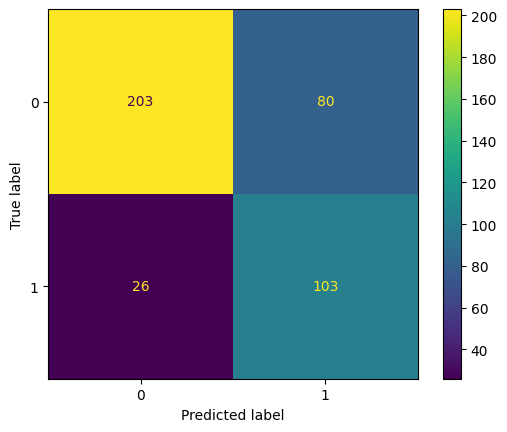

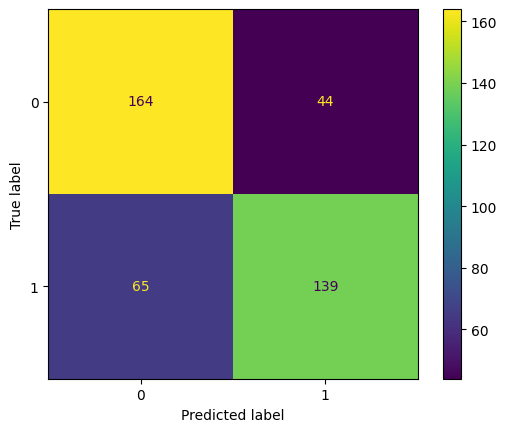

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )
    best_acc_model = models[test_eval["accuracy"].argmax()]
    ConfusionMatrixDisplay(
        confusion_matrix(best_acc_model.predict(X_test), y_test)
    ).plot()

    best_f1_model = models[test_eval["f1"].argmax()]
    ConfusionMatrixDisplay(
        confusion_matrix(best_f1_model.predict(X_test), y_test)
    ).plot()
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Answer to (o):</font>**
F1-score: The model is well balanced all around, but it has a lot of false negatives. (Precision and Recall are both high)

Accuracy: The model is getting high TNs and FPs. (Recaal is high, but Precision is low)

- **(p)** Finally, draw the ROC curves for the scoring classifiers and add the thresholded models to the plot using our given code, on the training data. Is some model dominating over any other (higher everywhere)? What are the main differences between the ROC curves on train and test data?

In [22]:
def roc_plot(models, thresholded_models, X, y):
    fig = plt.figure(figsize=(8, 8))
    for model in models:
        probs = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, probs)
        fpr, tpr, thr = roc_curve(y, probs)
        plt.plot(
            fpr,
            tpr,
            label="{} (AUC={:.2f})".format(str(model.estimator).split("(")[0], auc),
        )
    for t_model in thresholded_models:
        y_pred = t_model.predict(X)
        tpr = np.sum(np.logical_and(y_pred, y == 1)) / np.sum(y == 1)
        fpr = np.sum(np.logical_and(y_pred, y == 0)) / np.sum(y == 0)
        plt.plot(fpr, tpr, "x", label="{}".format(str(t_model)))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

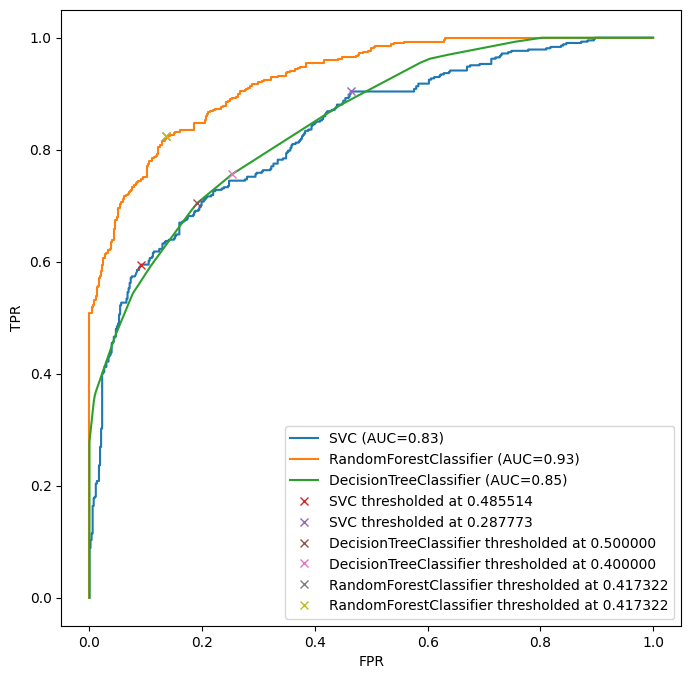

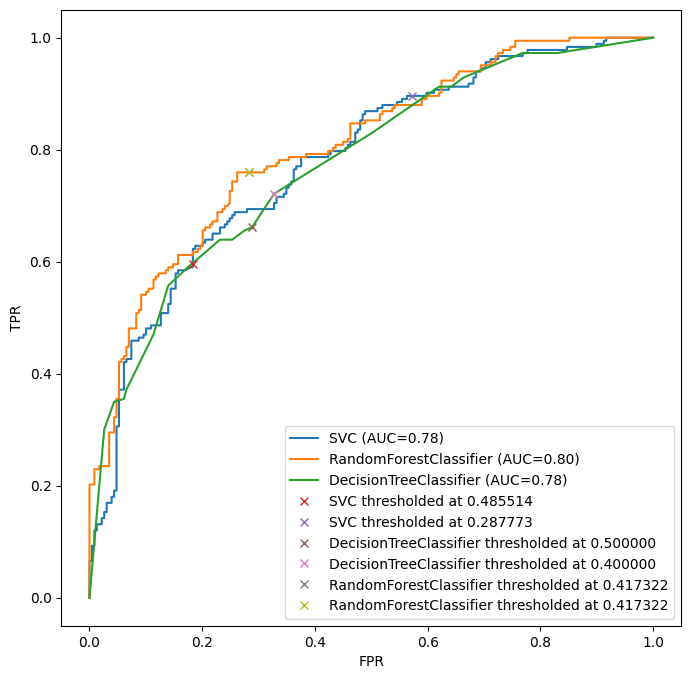

In [23]:
roc_plot(
    [svm_tuned, rf_tuned, dt_tuned],
    [svm_opt_acc, svm_opt_f1, dt_opt_acc, dt_opt_f1, rf_opt_acc, rf_opt_f1],
    X_train,
    y_train,
)


roc_plot(
    [svm_tuned, rf_tuned, dt_tuned],
    [svm_opt_acc, svm_opt_f1, dt_opt_acc, dt_opt_f1, rf_opt_acc, rf_opt_f1],
    X_test,
    y_test,
)

**<font color='purple'>Answer to (p):</font>**
For sure ROC curves on the train data are higher than the test data.
RandomForsets is little bit better in the test set, but on the training set, RandomForests is quite dominating.

Random Forest is over-fitted the data as there is a big difference between the train and test ROC curves.

Both Decision Tree and SVM are less over-fitted than Random Forest.

## Task 2: Logistic regression (4 points)

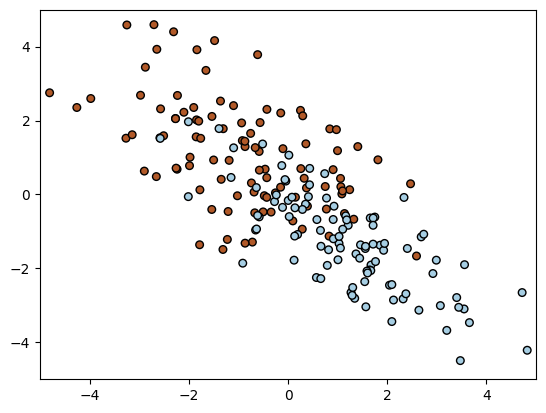

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_synthetic_data(n_instances):
    n_positives = round(n_instances/2)
    n_negatives = n_instances - n_positives
    X = np.zeros((n_instances,2))
    X[:n_positives,:] = np.random.multivariate_normal((-1,+1),((2,-1),(-1,2)),n_positives)
    X[n_positives:,:] = np.random.multivariate_normal((+1,-1),((2,-1.5),(-1.5,2)),n_negatives)
    Y = n_positives*[1]+n_negatives*[0]
    return(X,Y)

np.random.seed(0)
train_X, train_Y = create_synthetic_data(200)
test_X, test_Y = create_synthetic_data(20000)

plt.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired, edgecolors='k')
plt.axis([-5, 5, -5, 5])
plt.show()

- **(a)** Implement logistic regression using gradient descent of cross entropy. For this look up the formula for cross entropy and its gradient formulas from the lecture slides. Print out the final weights and bias term. Print out the number of iterations that the algorithm ran.  

**<font color='purple'>(a) Your implementation, prints out the final weights and bias term and the number of iterations:</font>**

In [25]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    # Logistic Regression Implementation from scratch
    class LogReg:
        def __init__(self):
            self.weights = None
            self.train_loss = np.array([])
            self.test_loss = np.array([])

        def __sigmoid(self, z):
            return 1 / (1 + np.exp(-z))

        def __cross_entropy_loss(self, y_true, y_pred):
            return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

        def predict(self, x):
            return self.__sigmoid(np.dot(x, self.weights))

        def fit(self, x_train, y_train, x_test, y_test, learning_rate=0.01, epochs=100):
            # Add Bias Term
            x_train = add_dummy_feature(x_train)
            x_test = add_dummy_feature(x_test)

            # Initialize Weights
            num_features = x_train.shape[1]
            self.weights = np.zeros(num_features)

            for _ in range(epochs):
                # Evaluating our model
                y_pred = self.predict(x_train)
                train_loss = self.__cross_entropy_loss(y_train, y_pred)

                y_pred_test = self.predict(x_test)
                test_loss = self.__cross_entropy_loss(y_test, y_pred_test)

                # Calculating gradients
                grad_w = np.dot(x_train.T, (y_pred - y_train)) / y_train.shape[0]

                # Updating weights
                self.weights = self.weights - learning_rate * grad_w

                # Keeping track of loss
                self.train_loss = np.append(self.train_loss, train_loss.mean())
                self.test_loss = np.append(self.test_loss, test_loss.mean())

            self.weights = self.weights

    lr = LogReg()

    lr.fit(
        np.array(train_X),
        np.array(train_Y),
        np.array(test_X),
        np.array(test_Y),
        learning_rate=0.01,
        epochs=10000,
    )

    print("Weights:", lr.weights)

    ##### YOUR CODE ENDS ##### (please do not delete this line)


except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

Weights: [ 0.17506491 -0.44154928  1.03308756]


- **(b)** Supplement each iteration of your above implementation with the calculation of cross entropy on the training data and on the test data. Make a plot with iteration number on the x-axis and cross entropy on the y-axis, with training and test loss shown in different colour. Discuss if you see signs of overfitting.

**<font color='purple'>(b) Your implementation making the plot:</font>**

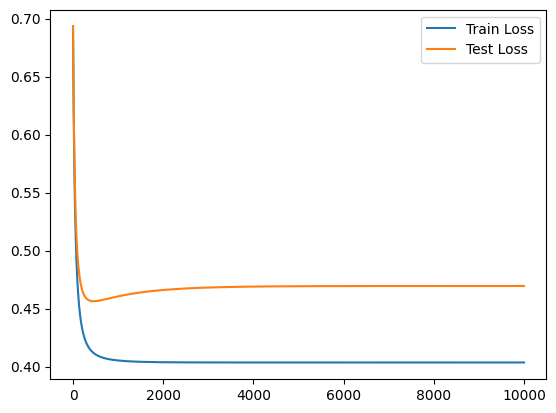

In [26]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    plt.plot(lr.train_loss, label="Train Loss")
    plt.plot(lr.test_loss, label="Test Loss")
    plt.legend()
    plt.show()
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Discuss if you see signs of overfitting:</font>**
Yeah, there is a sign of overfitting, as the training loss is decreasing, but the test loss is saturated.

- **(c)** Compare your learned weights and bias term to those obtained from sklearn implementation of logistic regression (sklearn.linear_model.LogisticRegression). Please use the parameter C value `C=1e10` (this is needed as by default sklearn logistic regression uses regularisation). Print out the final weights and bias term. Print out the differences from what your implementation found (subtract sklearn weights and bias from your weights and bias, respectively, and print out). The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate).

**<font color='purple'>(c) Your code to print the model learned with sklearn implementation of logistic regression and its difference from yours:</font>**

In [27]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )
    from sklearn.linear_model import LogisticRegression

    lr_sklearn = LogisticRegression(C=1e10)
    lr_sklearn.fit(train_X, train_Y)

    lr_sklearn_weights = np.append(lr_sklearn.intercept_, lr_sklearn.coef_)

    print(lr_sklearn_weights - lr.weights)
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

[2.23115113e-05 1.58240652e-05 2.95398631e-05]


- **(d)** Implement logistic regression using **stochastic** gradient descent of cross entropy. Print out the final weights and bias term. Print out the differences in weights and bias between this implementation and sklearn logistic regression (sklearn.linear_model.LogisticRegression, same as in subtask (c)). The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate).

**<font color='purple'>(d) Your implementation, prints out the final weights and bias term and the number of iterations, prints out the differences between your implementation and sklearn:</font>**

In [28]:
from numpy.random import randint
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    class StochasticLR:
        def __init__(self):
            self.weights = None
            self.train_loss = np.array([])
            self.test_loss = np.array([])

        def __sigmoid(self, z) -> np.ndarray:
            return 1 / (1 + np.exp(-z))

        def __cross_entropy_loss(self, y_true, y_pred) -> np.ndarray:
            return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

        def predict(self, x, w) -> np.ndarray:
            return self.__sigmoid(np.dot(x, w))

        def fit(
            self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            x_test: np.ndarray,
            y_test: np.ndarray,
            learning_rate=0.01,
            epochs=100,
        ):
            # Add Bias Term
            x_train = add_dummy_feature(x_train)
            x_test = add_dummy_feature(x_test)

            # Initialize Weights
            num_features = x_train.shape[1]
            w = np.zeros(num_features)

            for _ in range(epochs):
                # Evaluating our model
                y_pred = self.predict(x_train, w)
                train_loss = self.__cross_entropy_loss(y_train, y_pred)

                y_pred_test = self.predict(x_test, w)
                test_loss = self.__cross_entropy_loss(y_test, y_pred_test)

                # Taking a random record from the training set
                i = randint(x_train.shape[0])

                # Calculating gradients
                grad_w = (
                    np.dot(x_train[i].T, (y_pred[i] - y_train[i]))
                    / y_train.shape[0]
                )

                # Updating weights
                w = w - learning_rate * grad_w

                # Keeping track of loss
                self.train_loss = np.append(self.train_loss, train_loss.mean())
                self.test_loss = np.append(self.test_loss, test_loss.mean())

            self.weights = w

    ##### YOUR CODE ENDS ##### (please do not delete this line)
    slr = StochasticLR()
    slr.fit(
        np.array(train_X),
        np.array(train_Y),
        np.array(test_X),
        np.array(test_Y),
        learning_rate=0.01,
        epochs=100000,
    )
    print("Weights:", slr.weights)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

Weights: [ 0.05622704 -0.50214078  0.72976731]


- **(e)** About your stochastic gradient descent implementation make the same plot as you did in subtask **(b)** about gradient descent (cross entropy on train and test at each iteration). Discuss if you see signs of overfitting. Discuss the differences of plots about gradient descent and stochastic gradient descent.

**<font color='purple'>Your implementation making the plot:</font>**

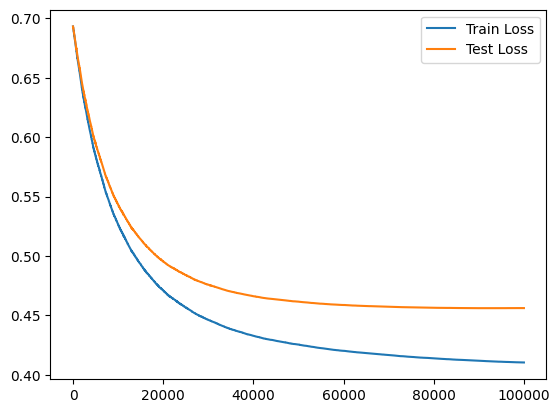

In [29]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    plt.plot(slr.train_loss, label="Train Loss")
    plt.plot(slr.test_loss, label="Test Loss")
    plt.legend()
    plt.show()

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Discuss if you see signs of overfitting:</font>**

Yes, there is a sign of overfitting, as the training loss is reached nearly 0.4, but the test loss much higher.

**<font color='purple'>Discuss the differences of plots about gradient descent and stochastic gradient descent:</font>**

The stochastic gradient descent plot is more noisy

- **(f)** Calculate and report accuracy of the logistic regression model on the test data. Do this on the model learned with sklearn in subtask **(c)**.

**<font color='purple'>(f) Your implementation reporting accuracy:</font>**

In [30]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    lr_sklearn_acc = accuracy_score(test_Y, lr_sklearn.predict(test_X))
    print("Sklearn Logistic Regression Accuracy:", lr_sklearn_acc)
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

Sklearn Logistic Regression Accuracy: 0.77765


- **(g)** Since we have generated the data ourselves with balanced classes drawn from two Gaussian distributions, we know what the optimal classifier is. The optimal classifier must predict positive whenever the likelihood of the positive class is higher than the likelihood of the negative class (as the class priors are equal, comparing the likelihoods is sufficient). For each test instance calculate these likelihoods and then calculate the accuracy of the optimal classifier on the test data (this classifier is known as the Bayes-optimal classifier).

**<font color='purple'>(g) Add to the following implementation and print accuracy of the Bayes-optimal classifier:</font>**

In [31]:
from scipy.stats import multivariate_normal


try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    pos_likelihood_func = multivariate_normal(mean=(-1, +1), cov=((2, -1), (-1, 2))).pdf
    neg_likelihood_func = multivariate_normal(
        mean=(+1, -1), cov=((2, -1.5), (-1.5, 2))
    ).pdf

    # Example usage:
    print(pos_likelihood_func(test_X))
    print(neg_likelihood_func(test_X))

    optimal_clf_pred = np.array(
        [neg_likelihood_func(test_X), pos_likelihood_func(test_X)]
    ).argmax(axis=0)

    print("Optimal model accuracy:", accuracy_score(test_Y, optimal_clf_pred))

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

[0.0412135  0.06427775 0.01805684 ... 0.0016481  0.09175873 0.00258289]
[0.02189665 0.00898235 0.1051964  ... 0.02608249 0.03792818 0.07491848]
Optimal model accuracy: 0.7926


- **(h)** Learn a SVM model with RBF kernel with default parameters and report the accuracy on the test data.

**<font color='purple'>(h) Your implementation reporting test accuracy of SVM:</font>**

In [32]:
try:
    from sklearn import svm

    svm_model = svm.SVC(kernel="rbf")


    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )
    svm_model.fit(train_X, train_Y)
    svm_model_acc = accuracy_score(test_Y, svm_model.predict(test_X))
    print("SVM Accuracy:", svm_model_acc)

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

SVM Accuracy: 0.78245


- **(i)** Draw the decision boundaries of the logistic regression model learned in **(c)**, SVM model learned in **(h)** and the Bayes-optimal model (explained in **(g)**). Discuss whether logistic regression or SVM learned a better model and explain why.

**<font color='purple'>Fill the gaps in the following code:</font>**

In [33]:
def make_plots(lr_model, svm_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = np.sign(
        pos_likelihood_func(xx) / (pos_likelihood_func(xx) + neg_likelihood_func(xx))
        - 0.5
    )
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = np.sign(lr_model.predict(xx) - 0.5).reshape(x1.shape)
    svm_pred = np.sign(svm_model.predict(xx) - 0.5).reshape(x1.shape)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        pred = [lr_pred, svm_pred, opt_pred][i]
        ax = axes[i]
        ax.imshow(
            pred,
            interpolation="nearest",
            extent=(x1.min(), x1.max(), x2.min(), x2.max()),
            aspect="auto",
            origin="lower",
            cmap=plt.cm.PuOr_r,
        )
        contours = ax.contour(x1, x2, pred, levels=[0], linewidths=2)
        ax.scatter(
            train_X[:, 0],
            train_X[:, 1],
            s=30,
            c=train_Y,
            cmap=plt.cm.Paired,
            edgecolors="k",
        )
        ax.axis([-5, 5, -5, 5])
    plt.show()

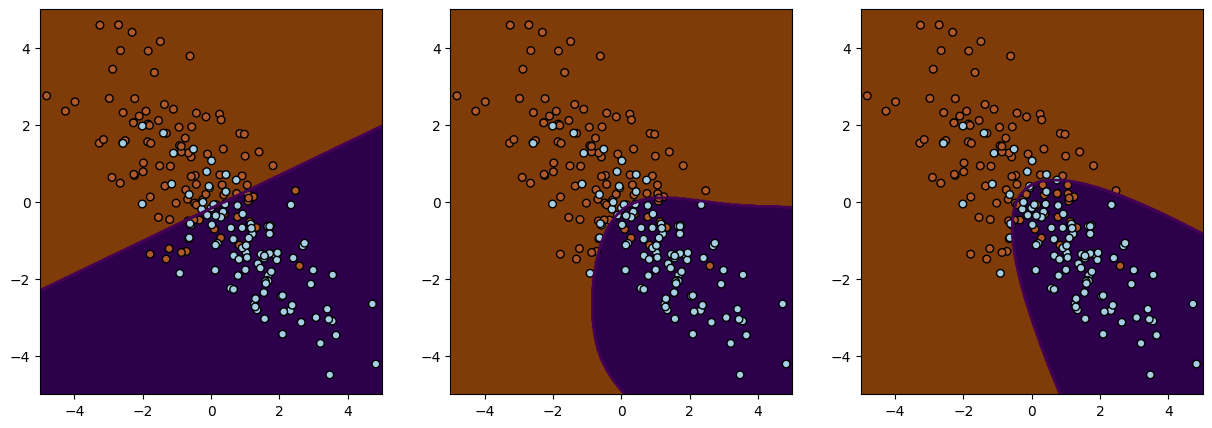

In [34]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")

    lr_model = lr_sklearn
    svm_model = svm_model
    make_plots(lr_model, svm_model)

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Discuss whether logistic regression or SVM learned a better model and explain why:</font>**

SVM is doing better than Logistic Regression, as it's way near to the optimal classifier.

- **(j)** Use the logistic regression model from subtask **(c)** to obtain class probability estimates on the test data (note that you can easily do **(c)** even if you did not solve **(a)** and **(b)**). Evaluate these probabilities with cross entropy with respect to the actual class. For this implement a function calculating cross entropy. Report the value of cross entropy.

**<font color='purple'>Fill the gaps in the following code and report cross entropy:</font>**

In [35]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    lr_model = lr_sklearn
    class_prob_estimates = lr_model.predict_proba(test_X)
    print(class_prob_estimates[:10, :])

    def cross_entropy(predicted_probabilities, actual_classes):
        result = 0
        for i in range(len(actual_classes)):
            result += actual_classes[i] * np.log(predicted_probabilities[i][1]) + (
                1 - actual_classes[i]
            ) * np.log(predicted_probabilities[i][0])
        return result

    print(cross_entropy(class_prob_estimates, test_Y))

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

[[0.4745888  0.5254112 ]
 [0.03979416 0.96020584]
 [0.80149511 0.19850489]
 [0.04127024 0.95872976]
 [0.27335474 0.72664526]
 [0.65204293 0.34795707]
 [0.27016351 0.72983649]
 [0.00627124 0.99372876]
 [0.08479588 0.91520412]
 [0.00597438 0.99402562]]
-9389.097841691999


- **(k)** Apply Platt scaling (also called logistic calibration) on the SVM model from **(h)**. Evaluate the resulting probabilities with cross entropy and report the result.

**<font color='purple'>Fill the gaps in the following code and report cross entropy:</font>**

In [36]:
from sklearn.calibration import CalibratedClassifierCV

svm_cal = CalibratedClassifierCV(svm_model, cv=2, method="sigmoid")
svm_cal.fit(train_X, train_Y)
svm_cal_prob = svm_cal.predict_proba(test_X)

try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    # calculate and print cross entropy on the predicted probabilities
    print(cross_entropy(svm_cal_prob, test_Y))

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

-9524.153072490893


- **(l)** Draw the 0.25-, 0.5- and 0.75-probability lines (also called iso-lines) of the logistic regression model, calibrated SVM model and the Bayes-optimal model. Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why.

**<font color='purple'>Fill the gaps in the following code:</font>**

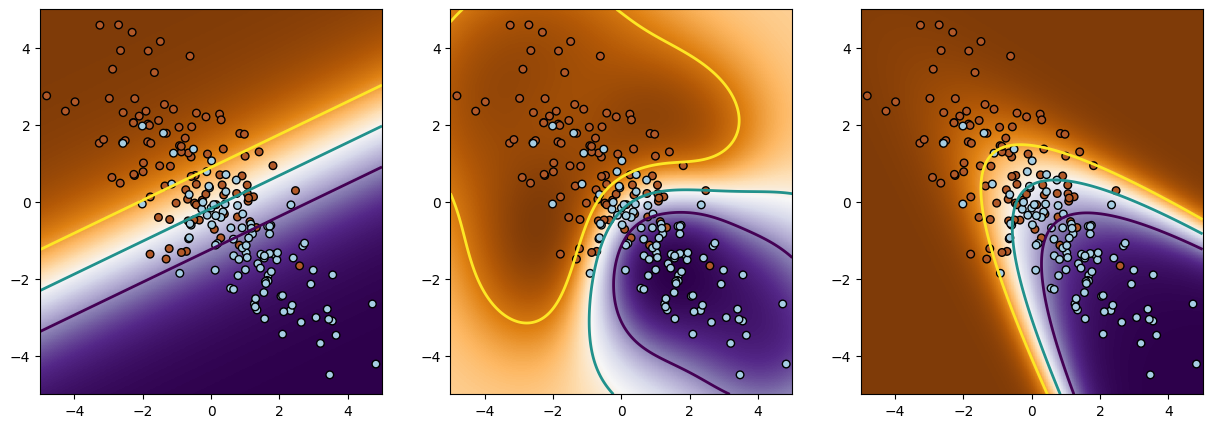

In [37]:
def make_prob_plots(lr_model, svm_cal_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = pos_likelihood_func(xx) / (
        pos_likelihood_func(xx) + neg_likelihood_func(xx)
    )
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = lr_model.predict_proba(xx)[:, 1].reshape(x1.shape)
    svm_cal_pred = svm_cal_model.predict_proba(xx)[:, 1].reshape(x1.shape)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        pred = [lr_pred, svm_cal_pred, opt_pred][i]
        ax = axes[i]
        ax.imshow(
            pred,
            interpolation="nearest",
            extent=(x1.min(), x1.max(), x2.min(), x2.max()),
            aspect="auto",
            origin="lower",
            cmap=plt.cm.PuOr_r,
        )
        contours = ax.contour(x1, x2, pred, levels=[0.25, 0.5, 0.75], linewidths=2)
        ax.scatter(
            train_X[:, 0],
            train_X[:, 1],
            s=30,
            c=train_Y,
            cmap=plt.cm.Paired,
            edgecolors="k",
        )
        ax.axis([-5, 5, -5, 5])
    plt.show()


try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    # raise NotImplementedError(
    #     'You need to remove "raise NotImplementedErrors" lines after writing your code!'
    # )

    lr_model = lr_sklearn
    svm_cal_model = svm_cal  # put the calibrated SVM model here (Platt scaling applied on the SVM model)
    make_prob_plots(lr_model, svm_cal_model)

    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED, "TODO:", e, CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why:</font>**


 ## <font color='red'>This was the last task! Please restart and run all before submission!</font>